In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import random
import helper_functions
import pandas as pd
import os
import seaborn as sns
import derivative_calculator
import warnings
from scipy.signal import savgol_filter
warnings.filterwarnings('ignore')

helper = helper_functions.HelperFunctions()

# Contents

* [Preprocess data](#preprocess)
* [Exclude trials/participants](#exclude)
* [Save finalized data](#save)

# Preprocess data <a class="anchor" id="preprocess"></a>

When reading the data, we set the index to self.index to be able to transfer the results of processing the dynamics dataframe to the choices dataframe. This is also convenient for data wrangling (e.g., `dynamics.loc[subj_id, task, trial_no])`. However, we also keep index as columns (drop=False) for more convenient pre-processing and plotting. Having the same data as a column and as an index is not very pythonic, but is justified here IMO. Because of this, pandas throws tons of warnings here and there, but those can be ignored so far.     

In [2]:
def read_data(path='data', index=['subj_id', 'task', 'trial_no']):
    file_path = os.path.join(path, '%s.txt')

    choices = pd.read_csv(file_path % 'choices', sep='\t')
    choices.set_index(index, inplace=True, drop=False)
    dynamics = pd.read_csv(file_path % 'dynamics', sep='\t')
    dynamics.set_index(index, inplace=True, drop=False)

    dynamics = dynamics.rename(columns={'timestamp': 't'})
    
    dynamics = dynamics.join(choices.option_chosen)

    return choices, dynamics

def get_random_traj(choices, dynamics):
    return dynamics.loc[choices.sample().index]

In [3]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'

choices, dynamics = read_data(data_path)

Express mouse coordinates in pixels

In [4]:
dynamics.loc[dynamics.task=='mouse', 'x'] *= 860
dynamics.loc[dynamics.task=='mouse', 'y'] *= 540

### Dealing with missing data and noise in walking trajectories

Checking missing data in walking trajectories

In [5]:
print("Data loss rate in walking trials: %f" % 
      (len(dynamics[(dynamics.task=='walking')&(dynamics.x.isna())])/len(dynamics[dynamics.task=='walking'])))

Data loss rate in walking trials: 0.025231


In [6]:
def get_data_loss_rate(trajectory):
    return len(trajectory[(trajectory.x.isna())])/len(trajectory)
data_loss_rate = dynamics.groupby(dynamics.index.names).apply(get_data_loss_rate)

How many trials are there with at least 10% data loss?

In [7]:
print(len(data_loss_rate[data_loss_rate>0.1]))

14


In [8]:
print(data_loss_rate[data_loss_rate>0.1])

subj_id  task     trial_no
1122     walking  23          0.377737
1474     walking  42          0.474265
3720     walking  27          0.201022
4232     walking  44          0.216149
4679     walking  36          0.586645
                  38          0.126812
5778     walking  27          0.168798
5781     walking  10          0.849146
5985     walking  17          0.669086
                  34          0.264664
6920     walking  24          0.179353
7921     walking  2           0.105469
                  27          0.425210
9970     walking  1           0.500000
dtype: float64


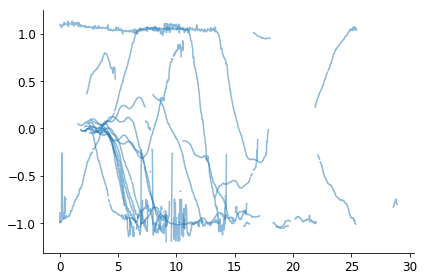

In [9]:
fig, ax = plt.subplots(1)
helper.plot_trajectories(dynamics[data_loss_rate>0.1], kind='time', ax=ax)

Let's exclude these trajectories and interpolate missing data in all the others

In [10]:
choices = choices[data_loss_rate<0.1]
dynamics = dynamics[data_loss_rate<0.1]

In [11]:
dynamics.loc[choices.task=='walking', ['x', 'y']] = (dynamics.loc[choices.task=='walking', ['x', 'y']].
                                                     groupby(choices.index.names).transform(pd.DataFrame.interpolate))

# delete remaining nans (which are still left at the start of some trials even after interpolate())
dynamics = dynamics.dropna(subset=['x', 'y'])

Filter out noise in the walking data

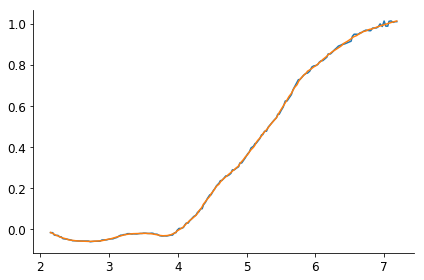

In [12]:
traj = get_random_traj(choices[choices.task=='walking'], dynamics[dynamics.task=='walking'])
plt.plot(traj.t, traj.x)
plt.plot(traj.t, savgol_filter(traj.x, window_length=21, polyorder=2))

In [13]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
dynamics.loc[choices.task=='walking', ['x', 'y']] = (dynamics.loc[choices.task=='walking', ['x', 'y']].
                                                     groupby(choices.index.names).transform(apply_filter))

### Discarding trials with problematic Kinect data

Calculate derivatives

In [14]:
dc = derivative_calculator.DerivativeCalculator()        
dynamics = dc.append_derivatives(dynamics)

In [15]:
v_max = dynamics.groupby(choices.index.names).apply(lambda traj: abs(traj.vy).max())

We might want to exclude the trials with extreme max velocity (this indicates 'jumping', where Kinect lost track of the subject in the middle of the trial), like this one

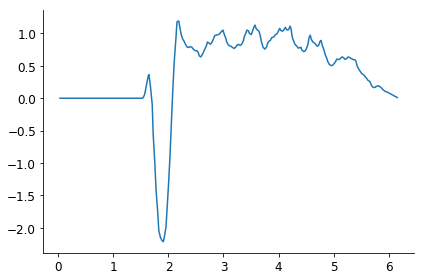

In [16]:
traj = dynamics.loc[choices[choices.task=='walking'].loc[(v_max>1.5)].sample().index]
plt.plot(traj.t, traj.vy)

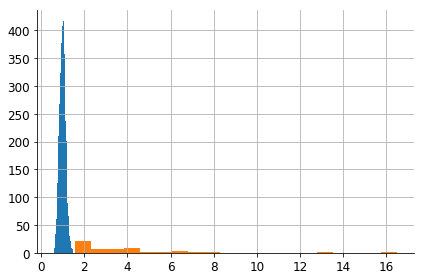

In [17]:
v_max_w = v_max[v_max.index.get_level_values('task')=='walking']
v_max_w[v_max_w<1.5].hist(bins=20)
v_max_w[v_max_w>1.5].hist(bins=20)

There aren't many such trials

In [18]:
len(choices[choices.task=='walking'].loc[v_max>1.5])

53

In [19]:
choices = choices[(choices.task=='mouse') | ((choices.task=='walking') & (v_max<1.5))]
dynamics = dynamics[(dynamics.task=='mouse') | ((dynamics.task=='walking') & (v_max<1.5))]

We also exclude trials with non-positive initial velocity. These trials result from a Kinect glitch: the recording started before the participant left the deadzone

In [20]:
v_first = dynamics.groupby(choices.index.names).vy.first()

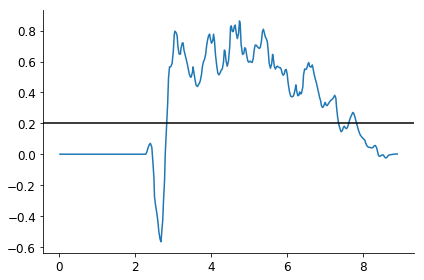

In [21]:
traj = dynamics.loc[choices.loc[(choices.task=='walking') & (v_first<=0.01)].sample().index]
plt.plot(traj.t, traj.vy)
plt.axhline(0.2, color='k')

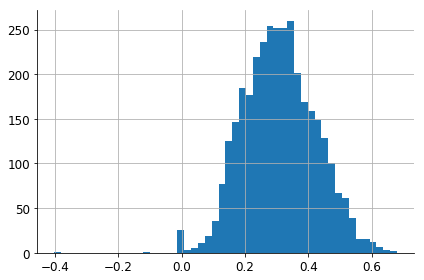

In [22]:
v_first[v_first.index.get_level_values('task')=='walking'].hist(bins=50)

Only a few such trials are excluded

In [23]:
len(choices[(choices.task=='walking') & (v_first<=0.01)])

28

In [24]:
choices = choices[(choices.task=='mouse') | ((choices.task=='walking') & (v_first>0.01))]
dynamics = dynamics[(dynamics.task=='mouse') | ((dynamics.task=='walking') & (v_first>0.01))]

### Shift origin

Shift every trajectory so that on average they all start at $t=0$ around (0,0)

In [25]:
def transform_xy(dynamics):
    starting_points = dynamics.groupby(by=['subj_id', 'trial_no']).first()
    dynamics.x = dynamics.x - starting_points.mean(axis=0).x
    dynamics.y = dynamics.y - starting_points.mean(axis=0).y

    return dynamics

In [26]:
dynamics.loc[choices.task=='mouse'] = transform_xy(dynamics.loc[choices.task=='mouse'])
dynamics.loc[choices.task=='walking'] = transform_xy(dynamics.loc[choices.task=='walking'])

dynamics.loc[:, 't'] = dynamics.t.groupby(by=choices.index.names).transform(lambda t: (t-t.min()))

If needed, resample trajectories so that each of them has exactly 101 data points

In [27]:
def resample_trajectory(trajectory, n_steps=101):
    t_regular = np.linspace(trajectory.t.min(), trajectory.t.max(), n_steps + 1)
    x_interp = np.interp(t_regular, trajectory.t.values, trajectory.x.values)
    y_interp = np.interp(t_regular, trajectory.t.values, trajectory.y.values)
    traj_interp = pd.DataFrame([t_regular, x_interp, y_interp]).transpose()
    traj_interp.columns = ['t', 'x', 'y']

    return traj_interp

def apply_trajectory_resampling(choices, dynamics, n_steps=101):
    dynamics = dynamics.groupby(by=['subj_id', 'task', 'trial_no']).apply(resample_trajectory)
    dynamics = dynamics.reset_index(drop=False)
    dynamics = dynamics.drop(['level_3'], axis=1)
    dynamics = dynamics.set_index(choices.index.names, drop=False)

    return dynamics

In [28]:
# dynamics = apply_trajectory_resampling(choices, dynamics)

Flip the trajectories such that the SS option is always on the left and LL option is on the right

In [29]:
dynamics.loc[~choices.is_ss_on_left, ['x']] *= -1

Calculate derivatives again after resampling and flipping (double work can be avoided but we keep it as is for clarity)

In [30]:
dc = derivative_calculator.DerivativeCalculator()        
dynamics = dc.append_derivatives(dynamics)

Calculate trajectory measures

In [31]:
def get_maxd(trajectory):
    alpha = np.arctan((trajectory.y.iloc[-1] - trajectory.y.iloc[0]) / \
                      (trajectory.x.iloc[-1] - trajectory.x.iloc[0]))
    d = (trajectory.x.values - trajectory.x.values[0]) * np.sin(-alpha) + \
        (trajectory.y.values - trajectory.y.values[0]) * np.cos(-alpha)

    if np.isnan(d).all():
        return pd.Series({'max_d': np.nan, 'idx_max_d': np.nan})
    elif abs(np.nanmin(d)) > abs(np.nanmax(d)):
        return pd.Series({'max_d': np.nanmin(d), 'idx_max_d': np.nanargmin(d)})
    else:
        return pd.Series({'max_d': np.nanmax(d), 'idx_max_d': np.nanargmax(d)})


def get_measures(choices, dynamics):
    choices['is_staircase'] = choices['is_staircase'].astype('bool')
    choices['ss_chosen'] = ((choices['option_chosen']) == 'ss')
    choices['chosen_amount'] = (choices['ss_amount'] * choices['ss_chosen'] +
                                choices['ll_amount'] * (~choices['ss_chosen']))
    choices['chosen_delay'] = (choices['ss_delay'] * choices['ss_chosen'] +
                               choices['ll_delay'] * (~choices['ss_chosen']))
    choices['amount_ratio'] = choices['ss_amount'] / choices['ll_amount']

    choices['amount_diff'] = choices['ll_amount'] - choices['ss_amount']
    choices['amount_increase'] = (choices['ll_amount'] - choices['ss_amount']) / choices['ss_amount']
    choices['LL_advantage'] = choices['amount_diff'] / choices['ll_delay']
    choices['Lambda'] = np.log(choices['LL_advantage'])
    # choices['type'] = 'MCQ'
    # choices.loc[choices.is_staircase, 'type'] = 'Staircase'

    choices = choices.drop(['response', 'start_time'], axis=1)

    choices = choices.join(dynamics.groupby(by=choices.index.names).apply(get_maxd), on=choices.index.names)
    choices['RT'] = dynamics.groupby(by=choices.index.names).apply(lambda traj: traj.t.max() - traj.t.min())

    # TODO: z-scoring should work within task (walking/mouse)
    #        choices['max_d_z'] = (choices['max_d'] - choices['max_d'].mean()) / choices['max_d'].std()


    return choices

In [32]:
choices = get_measures(choices,dynamics)

### Preprocessing TODO's
* Add separate columns for x- and y-coordinates in a task-normalized coordinate frame (where $(0,0)$ is the average starting point across all participants in the task, and $(-1, y)$ and $(1, y)$ are the average end-points of the trajectories)

# Exclude trials/participants <a class="anchor" id="exclude"></a>

In [33]:
print("Number of particpants: %i" % (len(choices.index.get_level_values('subj_id').unique())))

Number of particpants: 74


The idea is to have all data exclusion steps described in details in this notebook. However, if there is a potentially re-usable piece of code, it's better to put it in a py file (data_reader or data_analyser).

For every step of data exclusion, we might need to report how many trials/subjects were excluded and how we determined 

## Excluding participants based on extreme discounting behavior

In [34]:
k_values, ip = helper.get_k_values(choices, log=False)
extreme_k = k_values.loc[((k_values.mouse>0.98)&(k_values.walking>0.98)) | 
                         ((k_values.mouse<0.02)&(k_values.walking<0.02)), 'subj_id']

print("Number of excluded participants: %i" % (len(extreme_k)))
print(extreme_k.values)

choices = choices[~choices.index.get_level_values('subj_id').isin(extreme_k)]
dynamics = dynamics[~dynamics.index.get_level_values('subj_id').isin(extreme_k)]

Number of excluded participants: 14
[1095 1122 1282 1971 3846 4232 4550 4679 5389 5397 7095 7958 8767 9790]


## Exclusions based on RT and max-d

The ranges of allowed response times specified in the preregistration were 2 to 7s in the walking task and 1 to 5s in the mouse task. These values were based on the distributions observed in pilot data, however, in the full-scale experiment the variability was higher so we need to adjust the exclusion thresholds to keep as much valid data as possible.

### Walking task

(2, 15)

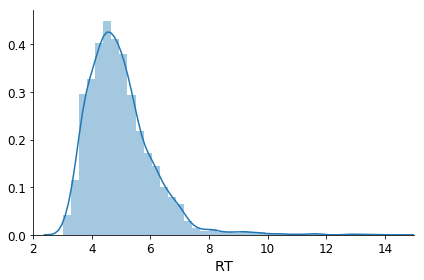

In [35]:
ax = sns.distplot(choices[choices.task=='walking'].RT)
ax.set_xlim(2,15)
# ax.set_yscale('log')

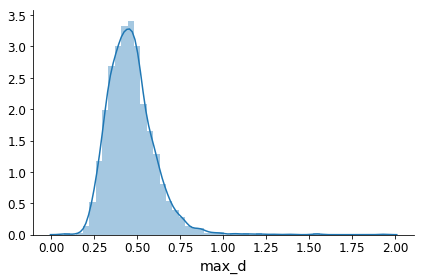

In [36]:
ax = sns.distplot(choices[choices.task=='walking'].max_d)

Based on these distributions, we will exclude the walking trials with `RT>8` and `max_d<0`. One might be tempted to exclude `max_d>1`, but these trials don't seem to be outliers

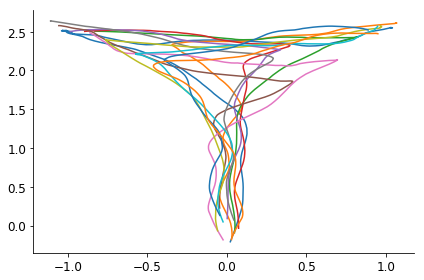

In [37]:
trials = choices[(choices.task=='walking')&(choices.max_d>1)].index
for traj in trials:
    plt.plot(dynamics.loc[traj].x, dynamics.loc[traj].y)

In [38]:
exclude_walking = ((choices.task=='walking') & ((choices.RT > 8) | (choices.max_d < 0)))

print(exclude_walking.sum())

choices = choices[~exclude_walking]
dynamics = dynamics[~exclude_walking]

49


### Mouse task

(0, 15)

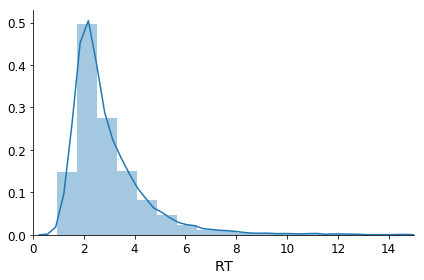

In [39]:
ax = sns.distplot(choices[choices.task=='mouse'].RT)
ax.set_xlim(0,15)

Max-d distributions

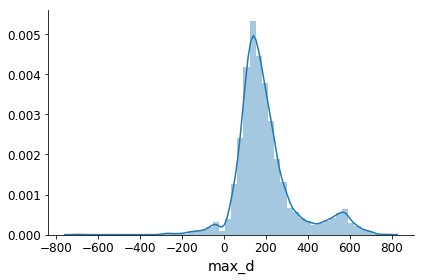

In [40]:
ax = sns.distplot(choices[choices.task=='mouse'].max_d)

Based on these distributions, we will exclude the mouse trials with `RT>8s` and `max_d<-300px`.

In [41]:
exclude_mouse = ((choices.task=='mouse') & ((choices.RT > 8)| (choices.max_d < -300)))

print(exclude_mouse.sum())

choices = choices[~exclude_mouse]
dynamics = dynamics[~exclude_mouse]

50


### Excluding slowdowns

In the pre-registration we specified that we will exclude walking trials in which subjects slow down below certain speed in the middle of the trial. The speed threshold of `0.2m/s` was determined based on the pilot data.

In [42]:
dynamics['v'] = np.sqrt(np.power(dynamics['vx'], 2) + np.power(dynamics['vy'], 2))

In [43]:
slowdown_trials = (dynamics.groupby(dynamics.index.names).apply(lambda traj: ((abs(traj.v)<0.2) & (traj.y<2)).any()))
print(len(choices[slowdown_trials]))
print(len(choices[slowdown_trials])/len(choices))

698
0.12769849981705086


In almost 700 trials (13% of all trials) subjects slowed down to 0.2m/s at least during one time step. As this threshold seems to be too strict to be applied as initially intended, we relax it by only discarding trials with total slowdown time more than 1 second

In [44]:
kinect_sampling_rate = 30 # in hertz, approximate sampling rate of Kinect v1
v_threshold = 0.2 # in m/s
t_slowdown = (dynamics.groupby(dynamics.index.names).apply(
    lambda traj: ((abs(traj.v)<0.2) & (traj.y<2)).sum()/kinect_sampling_rate))

In [45]:
exclude_slow = (t_slowdown.index.get_level_values('task')=='walking') & (t_slowdown>1)

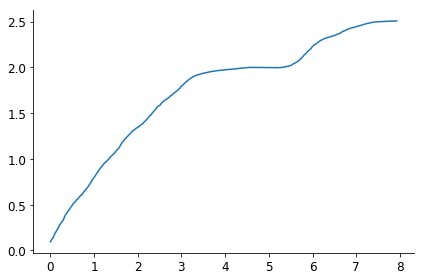

In [46]:
traj = get_random_traj(choices[exclude_slow], dynamics)
plt.plot(traj.t, traj.y)

There are 40 such trials

In [47]:
len(choices[exclude_slow])

40

In [48]:
choices = choices[~exclude_slow]
dynamics = dynamics[~exclude_slow]

## Resulting trajectories

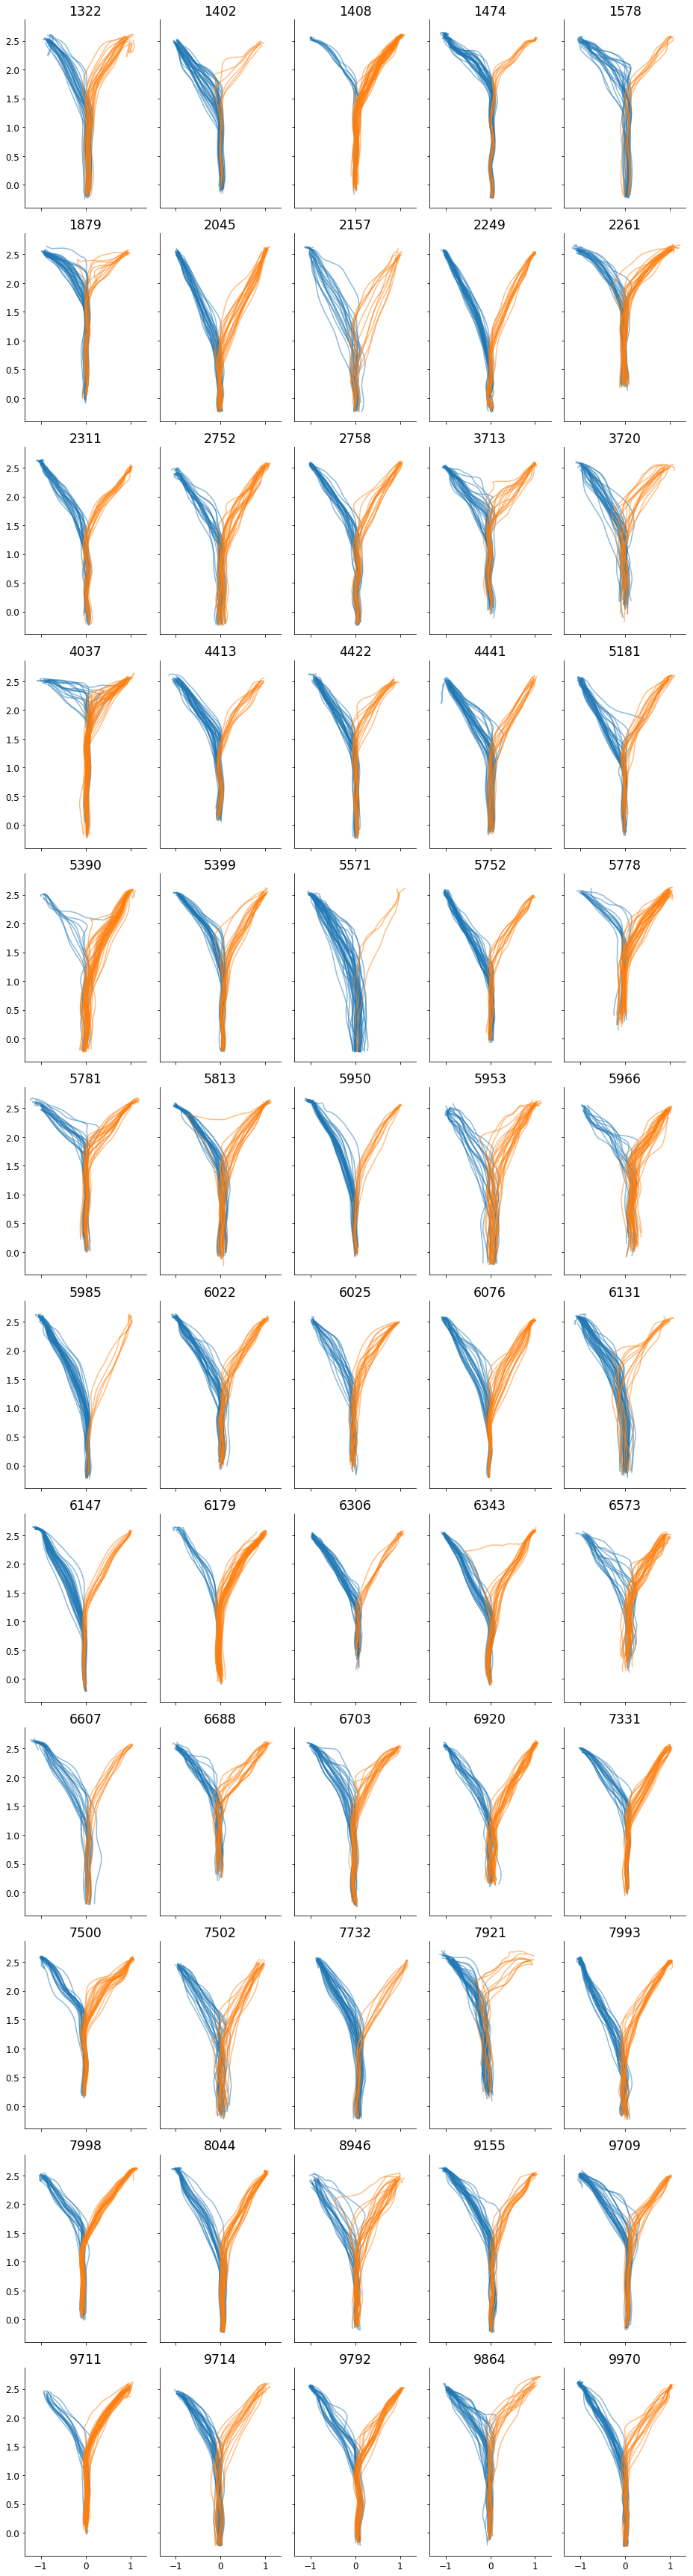

In [52]:
subjects = choices.subj_id.unique()

helper.plot_trajectories_by_subject(dynamics[dynamics.task=='walking'], subjects)

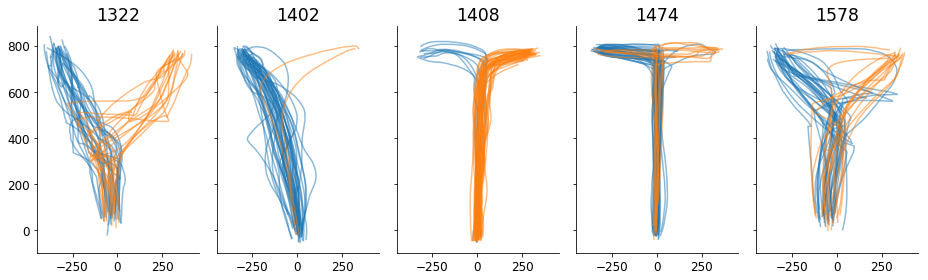

In [50]:
helper.plot_trajectories_by_subject(dynamics[dynamics.task == 'mouse'], subjects[0:5])

### Excluding subjects with few trials after other exclusions

If in some task a subject had more than 20% trials discarded ($0.8\times47 \approx 38$ trials left), we exclude that subject

In [54]:
n_trials = choices.groupby(['subj_id', 'task']).size()

In [59]:
k_values[k_values.subj_id.isin(n_trials[n_trials<38].index.get_level_values('subj_id'))]

task,subj_id,mouse,walking
7,1578,0.983105,0.959332
11,2157,0.957620,0.868222
14,2311,0.889769,0.921404
42,6025,0.759175,0.781749
50,6607,0.901056,0.986301
58,7732,0.972803,0.978567


# Saving finalized data <a class="anchor" id="save"></a>

In [ ]:
# saving preprocessed choices and dynamics for Analysis 1
choices.to_csv(os.path.join(data_path, 'choices_processed.txt'), index=False)
dynamics.to_csv(os.path.join(data_path, 'dynamics_processed.txt'), index=False)


# saving k-values for Analysis 2
k_values, ip = da.get_k_values(choices, log=False)
k_values_long = da.get_long_k_values(k_values, choices)

bias = da.get_ss_bias(data_path)
k_values_long = k_values_long.join(bias.set_index('subj_id'), on='subj_id')

k_values_long.to_csv(os.path.join(data_path, 'k_values.csv'), sep='\t', index=False)